In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm as colormaps

from importlib import reload

import environment as Env
import ray as Ray
import simulation as Sim

In [5]:
reload(Env)

# floor = lambda x: -550 * np.ones_like(x)
# floor = lambda x: -0.27 * x - 500
# floor = lambda x: -500 * np.sin(0.001 * x) - 750
floor = lambda x: np.maximum(-1 * np.exp(0.0005 * x) - 500, -1500 + 0.02*x)
# floor = lambda x: -5 * np.sin(0.01 * x) - 750

ceiling = lambda x: 0 * np.ones_like(x)

env = Env.Environment2D(
    floor=floor,
    ceiling=ceiling
)

In [6]:
reload(Ray)

# Source setup
source = np.array([0., 0.])
angle = -0.5
freq = 100

ray = Ray.Ray2D (env, source, freq, angle)
ray.propagate()  # verbose=True)

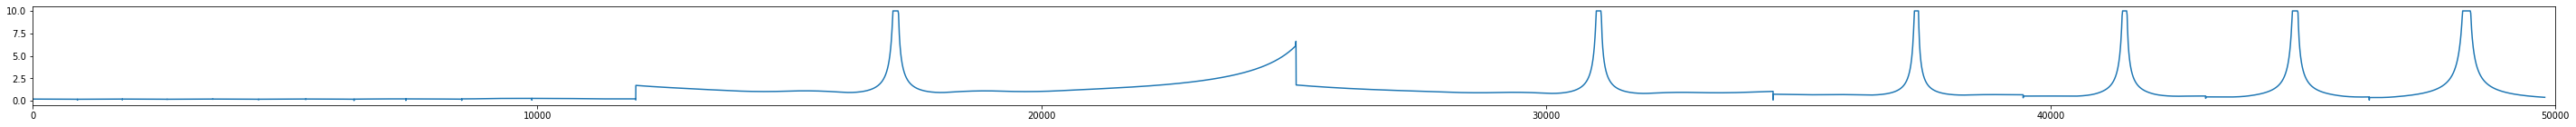

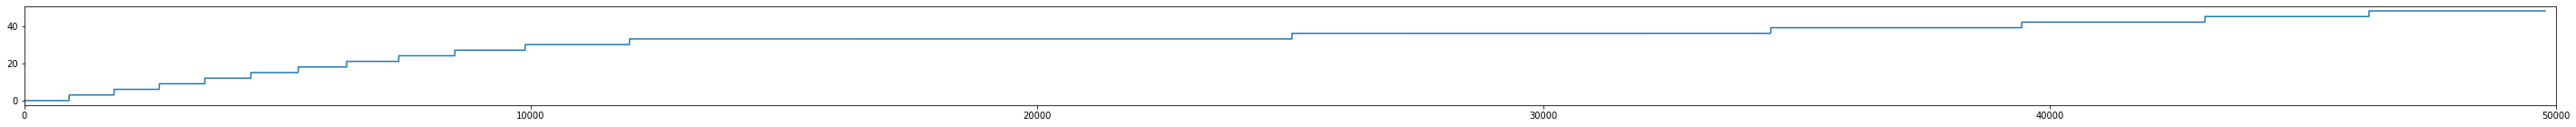

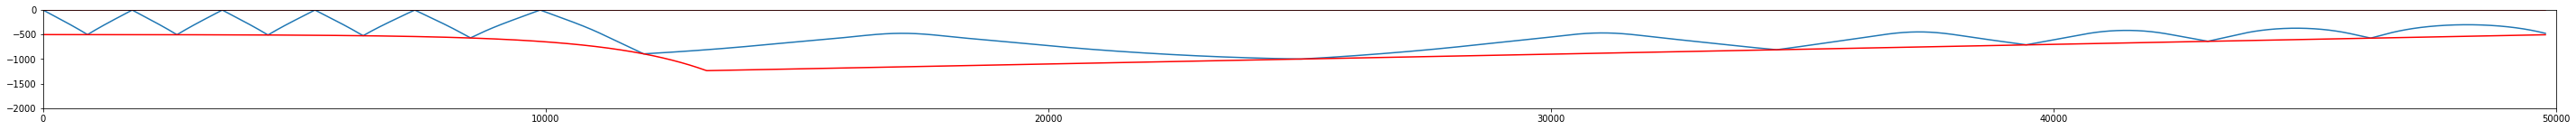

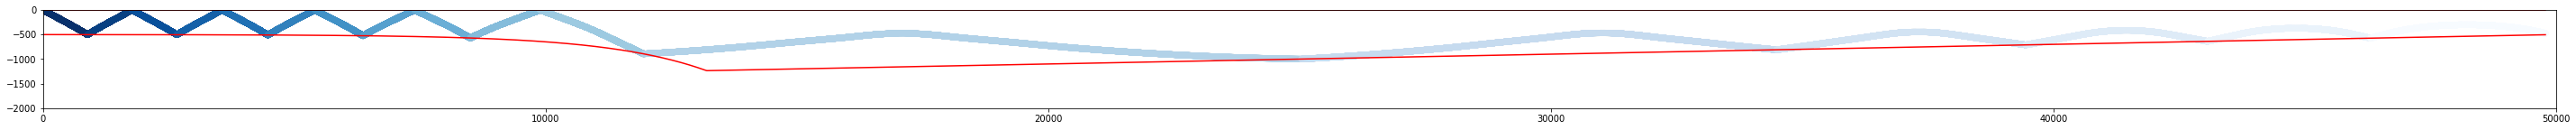

In [7]:
plt.figure(figsize=(50, 2))
plt.plot(ray.XZ[1:,0], ray.dL)
plt.xlim((0, 50000))
plt.show()

plt.figure(figsize=(50, 2))
plt.plot(ray.XZ[:,0], ray.A_dB)
plt.xlim((0, 50000))
plt.show()

plt.figure(figsize=(50, 2))
plt.plot(ray.XZ[:,0], ray.XZ[:,1])
plt.plot(ray.XZ[:,0], ceiling(ray.XZ[:,0]), c='red')
plt.plot(ray.XZ[:,0], floor(ray.XZ[:,0]), c='red')
# plt.xlim((env.range_min.x, env.range_max.x))
# plt.ylim((env.range_min.z, env.range_max.z))
plt.xlim((0, 50000))
plt.ylim((-2000, 0))
plt.show()

plt.figure(figsize=(50, 2))
plt.scatter(ray.XZ[:,0], ray.XZ[:,1], c=ray.A_dB, cmap=colormaps.Blues_r)
plt.plot(ray.XZ[:,0], ceiling(ray.XZ[:,0]), c='red')
plt.plot(ray.XZ[:,0], floor(ray.XZ[:,0]), c='red')
# plt.xlim((env.range_min.x, env.range_max.x))
# plt.ylim((env.range_min.z, env.range_max.z))
plt.xlim((0, 50000))
plt.ylim((-2000, 0))
plt.show()

In [20]:
reload(Ray)
reload(Env)
reload(Sim)

sim = Sim.Simulation2D (env)
# sim.add_rays (source, 100, -0.5, -0.6, -0.7, -0.8, -0.9, 1., dx_max=10, dz_max=10, n_rebounds_max=4, backprop=True)  # , verbose=True)
# sim.add_rays (source, 100, -0.5, -0.5001, -0.5002, -0.5003, -0.5004, dx_max=10, dz_max=10, backprop=False)  # , verbose=True)
# sim.add_rays (source, 100, -0.5, -0.500001, -0.500002, -0.500003, -0.50004, dx_max=10, dz_max=10, backprop=False)  # , verbose=True)

sim.add_rays (
    source,
    100,
    *[i/100 for i in range(-1, -100, -10)],
    dx_max=10,
    dz_max=10,
    backprop=True,
    # n_rebounds_max=4
)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [21]:
stop_reasons = [ray.stop_reason for ray in sim.get_rays()]
stop_reasons.sort()
stop_reasons_set = set(stop_reasons)
for sr in stop_reasons_set:
    n = stop_reasons.count(sr)
    print(f'{sr}: {n}')

exit-xmin: 99


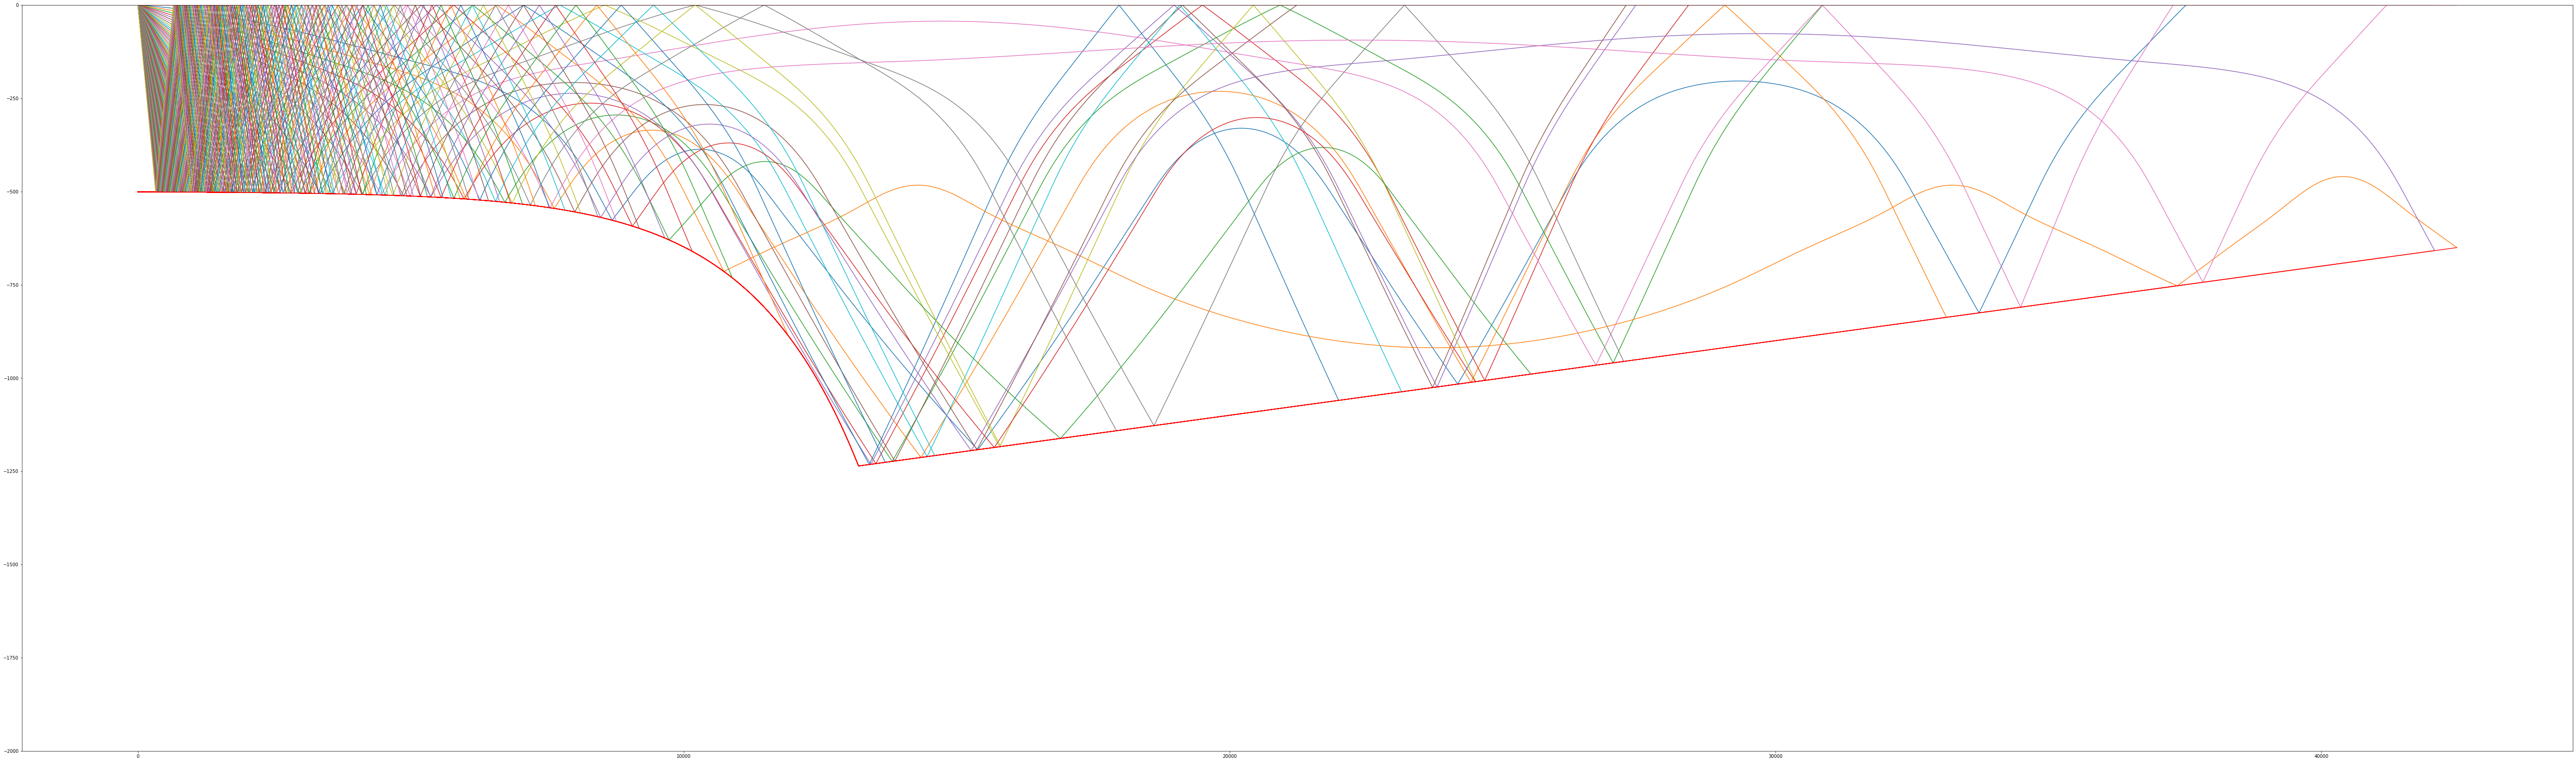

In [19]:
# plt.figure(figsize=(100, 4))
plt.figure(figsize=(100, 30))
for ray in sim.get_rays():
    plt.plot(ray.XZ[:,0], ray.XZ[:,1])
    plt.plot(ray.XZ[:,0], ceiling(ray.XZ[:,0]), c='red')
    plt.plot(ray.XZ[:,0], floor(ray.XZ[:,0]), c='red')
# plt.xlim((env.range_min.x, env.range_max.x))
# plt.ylim((env.range_min.z, env.range_max.z))
# plt.xlim((0, 50000))
# plt.ylim((-2000, 0))
plt.ylim(-5000, 0)
plt.show()

In [21]:
x = np.array([[1, 1, 2, 3, 4, 5], [1, 1, 2, 3, 4, 5]]).T
print(x.shape)
print(np.diff(x, axis=0))

(6, 2)
[[0 0]
 [1 1]
 [1 1]
 [1 1]
 [1 1]]


In [30]:
x = np.array([[0, 0, 0, 0, 0, 0], [1, 1, 2, 3, 4, 5]]).T
print(x)
print(np.linalg.norm(x, axis=1))

[[0 1]
 [0 1]
 [0 2]
 [0 3]
 [0 4]
 [0 5]]
[1. 1. 2. 3. 4. 5.]


In [52]:
z = np.array([-1, -2, -3, -4, -5])
a = np.array([-1, -1, -1, -1, -1])
print(np.multiply(z, a), z*a)
from physics.profile_velocity import calc_c
calc_c(z)

[1 2 3 4 5] [1 2 3 4 5]


array([1526.85095522, 1526.83411938, 1526.81741264, 1526.80083513,
       1526.78438699])

In [48]:
from physics.profile_absorption import calc_absorption_dB
calc_absorption_dB(10, z)

array([6.15376491e-06, 6.14666726e-06, 6.13956628e-06, 6.13246200e-06,
       6.12535446e-06])

In [67]:
u = np.ones((10))
print(u)
u[10:] *= -1
print(u)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
